In [2]:
# 📚 Step 1: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

In [3]:
# 🗂 Step 2: Define a Function to Load and Augment Data
def load_data(data_path, img_size=(150, 150), batch_size=32, val_split=0.2):
    """
    Loads training and validation datasets from a given directory using ImageDataGenerator.

    Args:
        data_path (str): The path to the dataset folder.
        img_size (tuple): Size to resize each image.
        batch_size (int): Number of images per batch.
        val_split (float): Portion of data to be used for validation.

    Returns:
        train_generator, val_generator: Data generators for training and validation.
    """

    datagen = ImageDataGenerator(
        rescale=1.0/255,        # Normalize image pixels to range [0, 1]
        shear_range=0.2,        # Apply random shear for augmentation
        zoom_range=0.2,         # Apply random zoom
        horizontal_flip=True,   # Randomly flip images horizontally
        validation_split=val_split  # Split data into training and validation sets
    )

    # Load training data
    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    # Load validation data
    val_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

In [4]:
# 🧠 Step 3: Define CNN Model Architecture
def build_cnn_model(num_classes, img_shape=(150, 150, 3), dropout=0.5):
    """
    Builds a simple Convolutional Neural Network model.

    Args:
        num_classes (int): Number of output classes.
        img_shape (tuple): Shape of input images.
        dropout (float): Dropout rate to prevent overfitting.

    Returns:
        model: Compiled Keras model.
    """

    model = Sequential()

    # First convolution layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten output to 1D and add dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))  # Dropout to reduce overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model

In [10]:
# This function builds a simple Keras Sequential model for image classification
def build_sequential_model(num_classes, img_shape=(150, 150, 3)):
    # Initialize the model as a sequential stack of layers
    model = Sequential([
        # Input layer that defines the shape of the input data
        InputLayer(input_shape=img_shape),
        # Flatten the 3D input (image) to 1D
        Flatten(),
        # Fully connected dense layer with ReLU activation
        Dense(128, activation='relu'),
        # Output layer with softmax activation for multi-class classification
        Dense(num_classes, activation='softmax')
    ])
    # Return the constructed model
    return model


In [5]:
# 📊 Step 4: Training and Evaluation Function
def train_and_evaluate(model, train_gen, val_gen, name, lr=0.001, epochs=15):
    """
    Compiles, trains, and evaluates the CNN model.

    Args:
        model: Compiled CNN model.
        train_gen: Training data generator.
        val_gen: Validation data generator.
        name (str): Model name (for plot titles).
        lr (float): Learning rate.
        epochs (int): Number of training epochs.

    Returns:
        history: Training history.
    """

    # Compile the model using Adam optimizer
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

    # Evaluate the model
    print(f"\nEvaluating {name} model...")
    val_gen.reset()  # Ensure correct batch order
    predictions = model.predict(val_gen)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())

    # Print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    # Plot accuracy over epochs
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return history

In [12]:
def load_test_data(test_path, img_size=(150, 150), batch_size=32):
    test_datagen = ImageDataGenerator(rescale=1.0/255)
    
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Important for correct predictions vs labels
    )
    
    return test_generator


In [24]:
def Show_confusion_matrix(model,test_gen):
    # Evaluate model on test data
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predict and show confusion matrix
    test_preds = model.predict(test_gen)
    test_pred_classes = np.argmax(test_preds, axis=1)
    test_true_classes = test_gen.classes
    labels = list(test_gen.class_indices.keys())
    
    print("Classification Report on Test Set:")
    print(classification_report(test_true_classes, test_pred_classes, target_names=labels))
    
    # Confusion matrix
    cm = confusion_matrix(test_true_classes, test_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Found 29920 images belonging to 4 classes.
Found 7480 images belonging to 4 classes.
Epoch 1/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 667s 712ms/step - accuracy: 0.3186 - loss: 1.3451 - val_accuracy: 0.4676 - val_loss: 1.1729
Epoch 2/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 475s 508ms/step - accuracy: 0.4047 - loss: 1.2012 - val_accuracy: 0.5068 - val_loss: 1.0734
Epoch 3/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 409s 437ms/step - accuracy: 0.4326 - loss: 1.1368 - val_accuracy: 0.5437 - val_loss: 1.0334
Epoch 4/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 375s 401ms/step - accuracy: 0.4533 - loss: 1.0964 - val_accuracy: 0.5674 - val_loss: 0.9642
Epoch 5/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 373s 398ms/step - accuracy: 0.4601 - loss: 1.0659 - val_accuracy: 0.5869 - val_loss: 0.9286

Evaluating CNN model...
234/234 ━━━━━━━━━━━━━━━━━━━━ 48s 203ms/step
                  precision    recall  f1-score   support

    MildDemented       0.22      0.14      0.17      1700
ModerateDemented       0.23      0.27      0.25      1700
     NonDemented

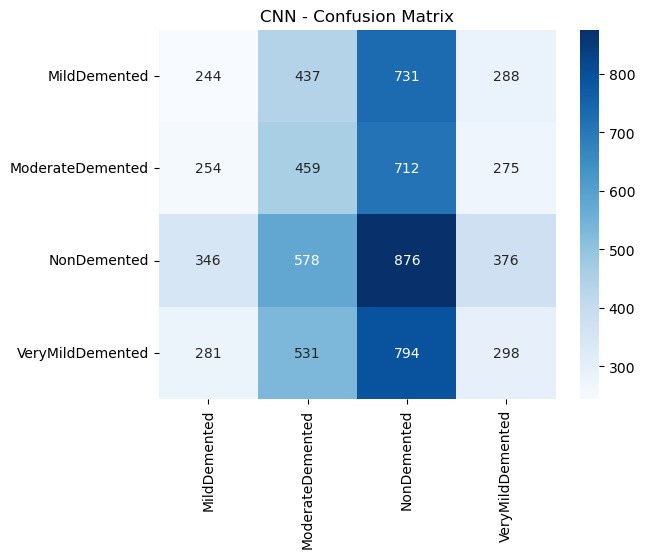

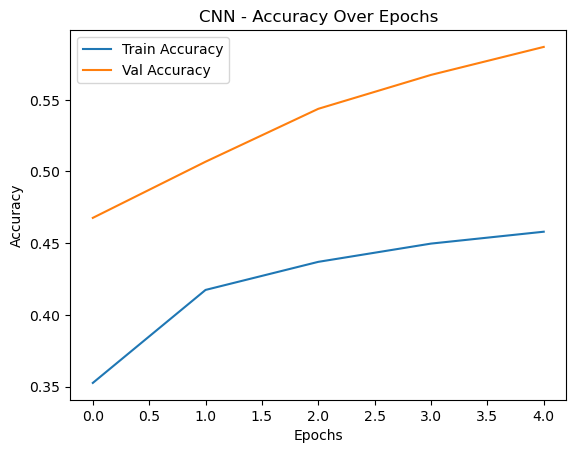

C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 288s 307ms/step - accuracy: 0.3381 - loss: 1.3927 - val_accuracy: 0.4238 - val_loss: 1.2171
Epoch 2/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 319s 341ms/step - accuracy: 0.4451 - loss: 1.2104 - val_accuracy: 0.4906 - val_loss: 1.1562
Epoch 3/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 290s 310ms/step - accuracy: 0.4879 - loss: 1.1503 - val_accuracy: 0.4884 - val_loss: 1.1418
Epoch 4/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 258s 276ms/step - accuracy: 0.5047 - loss: 1.1071 - val_accuracy: 0.5045 - val_loss: 1.0936
Epoch 5/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 276s 295ms/step - accuracy: 0.5103 - loss: 1.0950 - val_accuracy: 0.5214 - val_loss: 1.0644

Evaluating Keras Sequential model...
234/234 ━━━━━━━━━━━━━━━━━━━━ 48s 207ms/step
                  precision    recall  f1-score   support

    MildDemented       0.22      0.17      0.19      1700
ModerateDemented       0.22      0.27      0.24      1700
     NonDemented       0.29      0.40      0.34      2176
VeryMildDemented       0.25   

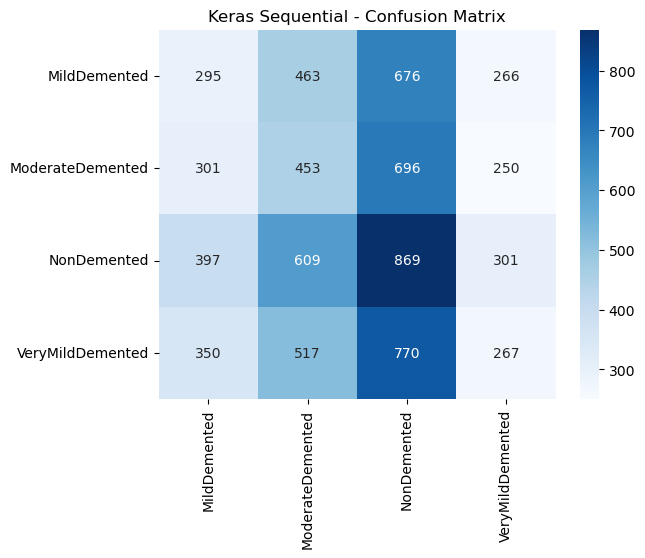

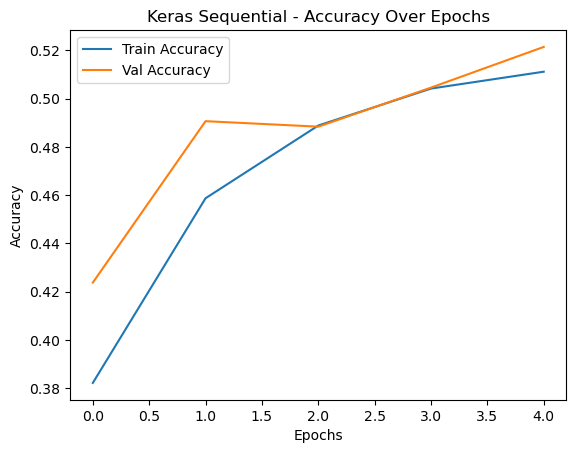

Found 8100 images belonging to 4 classes.


C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


254/254 ━━━━━━━━━━━━━━━━━━━━ 80s 316ms/step - accuracy: 0.5102 - loss: 1.1178
Test Loss: 0.9737
Test Accuracy: 0.5594
254/254 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step


NameError: name 'test_gen_2' is not defined

In [20]:
# 🧪 Step 5: Load Data and Train Model on Dataset 1 (4 Classes)
# Path to 4-class Alzheimer dataset
train_path_1 = "C://Users//gm010//NN//Alzheimer_MRI_4_classes_Split_Dataset//train"
# Assuming your test data is in this folder:
test_path_1 = "C://Users//gm010//NN//Alzheimer_MRI_4_classes_Split_Dataset//test"
# Load data
train_1, val_1 = load_data(train_path_1)

# Build CNN model
model_1_cnn = build_cnn_model(num_classes=4)

# Train and evaluate
history_1 = train_and_evaluate(model_1_cnn, train_1, val_1, name="CNN",lr=.0001,epochs=5)

model_1 = build_sequential_model(num_classes=4)

# 🧪 Train on 4-class Alzheimer data
history_1_2 = train_and_evaluate(model_1, train_1, val_1, name="Keras Sequential",lr=.0001,epochs=5)

# Load test data
test_gen_1 = load_test_data(test_path_1)

Show_confusion_matrix(model_1_cnn,test_gen_1)
Show_confusion_matrix(model_1,test_gen_1)


254/254 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.5102 - loss: 1.1178
Test Loss: 0.9737
Test Accuracy: 0.5594
254/254 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    MildDemented       0.70      0.39      0.50      3000
ModerateDemented       0.74      0.96      0.84      1500
     NonDemented       0.52      0.76      0.62      1920
VeryMildDemented       0.28      0.28      0.28      1680

        accuracy                           0.56      8100
       macro avg       0.56      0.60      0.56      8100
    weighted avg       0.58      0.56      0.54      8100



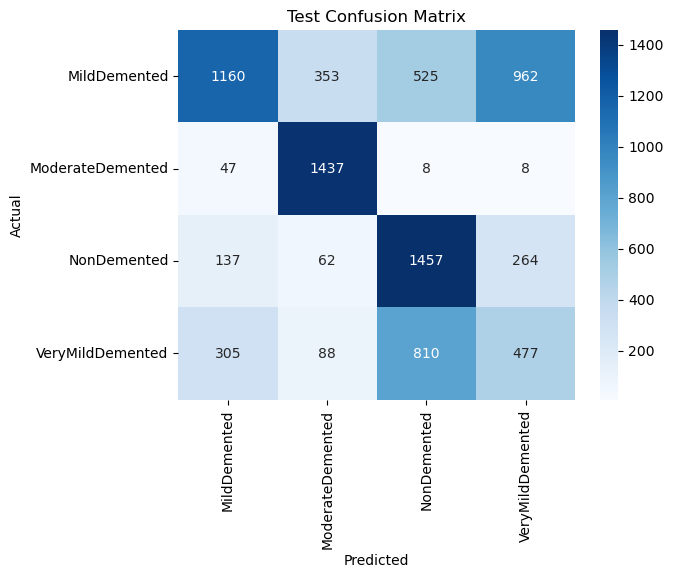

254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4962 - loss: 1.1452
Test Loss: 1.0461
Test Accuracy: 0.5209
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    MildDemented       0.65      0.41      0.50      3000
ModerateDemented       0.58      0.88      0.70      1500
     NonDemented       0.47      0.69      0.56      1920
VeryMildDemented       0.31      0.21      0.25      1680

        accuracy                           0.52      8100
       macro avg       0.50      0.55      0.50      8100
    weighted avg       0.52      0.52      0.50      8100



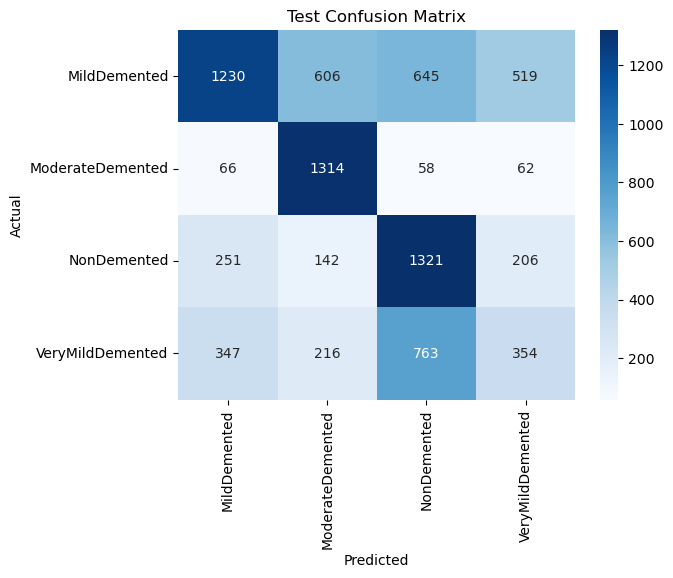

In [26]:
Show_confusion_matrix(model_1_cnn,test_gen_1)
Show_confusion_matrix(model_1,test_gen_1)

Found 26614 images belonging to 3 classes.
Found 6652 images belonging to 3 classes.
Epoch 1/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 398s 476ms/step - accuracy: 0.5559 - loss: 0.9586 - val_accuracy: 0.7148 - val_loss: 0.5637
Epoch 2/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 420s 505ms/step - accuracy: 0.6915 - loss: 0.6463 - val_accuracy: 0.7814 - val_loss: 0.4646
Epoch 3/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 424s 510ms/step - accuracy: 0.7170 - loss: 0.5742 - val_accuracy: 0.8059 - val_loss: 0.4122
Epoch 4/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 382s 459ms/step - accuracy: 0.7444 - loss: 0.5238 - val_accuracy: 0.8250 - val_loss: 0.3693
Epoch 5/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 372s 447ms/step - accuracy: 0.7683 - loss: 0.4931 - val_accuracy: 0.8346 - val_loss: 0.3567
Epoch 6/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 395s 474ms/step - accuracy: 0.7861 - loss: 0.4647 - val_accuracy: 0.8570 - val_loss: 0.3086
Epoch 7/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 365s 438ms/step - accuracy: 0.8022 - loss: 0.4299 - val_accuracy: 0.8652 - val_loss

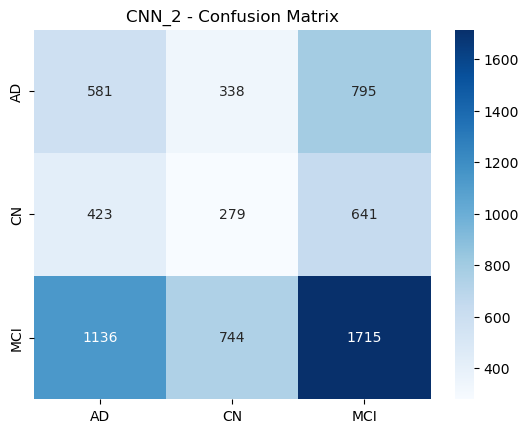

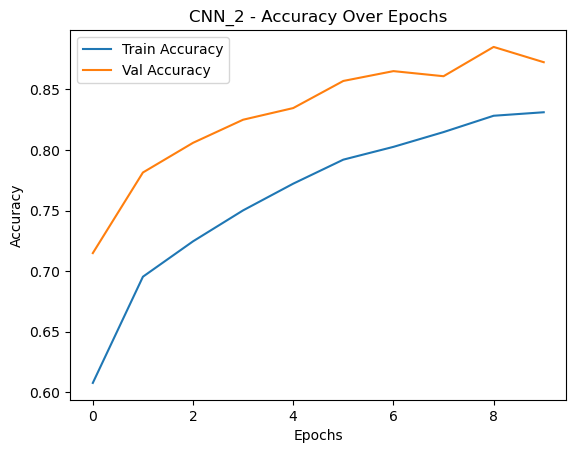

C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 251s 301ms/step - accuracy: 0.4963 - loss: 2.9715 - val_accuracy: 0.5579 - val_loss: 0.9103
Epoch 2/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 242s 291ms/step - accuracy: 0.5370 - loss: 0.9433 - val_accuracy: 0.5689 - val_loss: 0.8916
Epoch 3/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 230s 276ms/step - accuracy: 0.5551 - loss: 0.9250 - val_accuracy: 0.5866 - val_loss: 0.8845
Epoch 4/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 222s 267ms/step - accuracy: 0.5533 - loss: 0.9211 - val_accuracy: 0.5830 - val_loss: 0.8831
Epoch 5/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 266s 319ms/step - accuracy: 0.5629 - loss: 0.9089 - val_accuracy: 0.5571 - val_loss: 0.9121
Epoch 6/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 230s 277ms/step - accuracy: 0.5588 - loss: 0.9136 - val_accuracy: 0.5684 - val_loss: 0.9124
Epoch 7/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 253s 304ms/step - accuracy: 0.5709 - loss: 0.9006 - val_accuracy: 0.6051 - val_loss: 0.8626
Epoch 8/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 248s 298ms/step - accuracy: 0.5655 -

C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


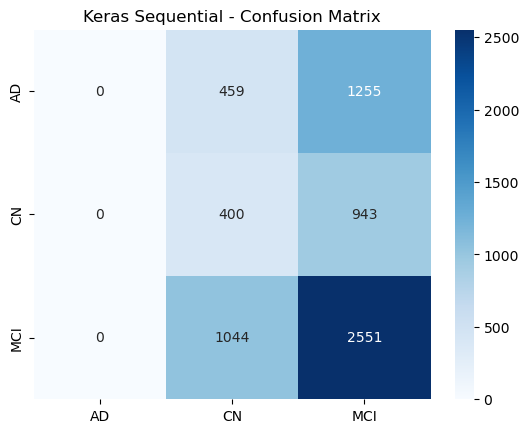

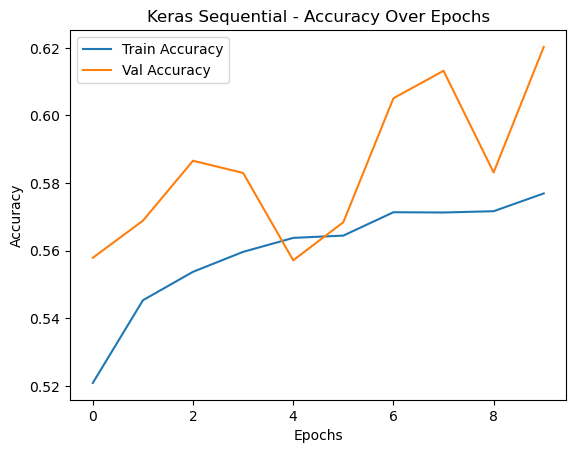

Found 5872 images belonging to 3 classes.


C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 58s 313ms/step - accuracy: 0.9110 - loss: 0.2590
Test Loss: 0.2822
Test Accuracy: 0.8750
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

          AD       0.71      0.92      0.80      1513
          CN       0.96      0.92      0.94      1186
         MCI       0.95      0.84      0.89      3173

    accuracy                           0.88      5872
   macro avg       0.88      0.89      0.88      5872
weighted avg       0.89      0.88      0.88      5872



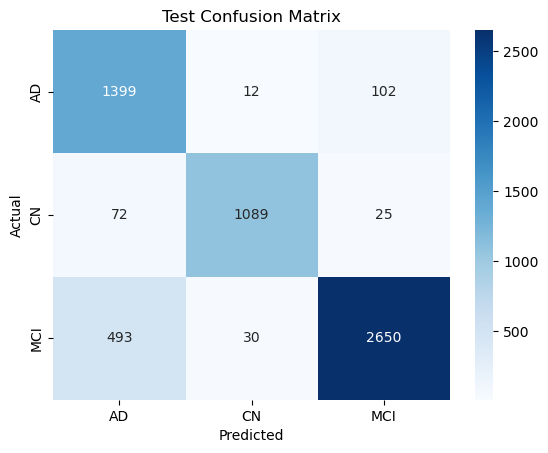

NameError: name 'model_nn_2' is not defined

In [30]:
# 🧪 Step 6: Load Data and Train Model on Dataset 2 (3 Classes)
# Path to 3-class Alzheimer dataset
train_path_2 = "C://Users//gm010//NN//Alzheimer_Split_3_classes_dataset//train"
# Assuming your test data is in this folder:
test_path_2 = "C://Users//gm010//NN//Alzheimer_Split_3_classes_dataset//test"
# Load data
train_2, val_2 = load_data(train_path_2)

# Build CNN model with slightly less dropout
model_2_cnn = build_cnn_model(num_classes=3, dropout=0.3)

# Train and evaluate
history_2 = train_and_evaluate(model_2_cnn, train_2, val_2, name="CNN_2",epochs=10)
# 🧠 Build dense NN model
model_2 = build_sequential_model(num_classes=3)

# 🧪 Train on 3-class Alzheimer data
history_2_2 = train_and_evaluate(model_2, train_2, val_2, name="Keras Sequential",epochs=10)

# Load test data
test_gen_2 = load_test_data(test_path_2)
Show_confusion_matrix(model_2_cnn,test_gen_2)
Show_confusion_matrix(model_nn_2,test_gen_2)

184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.3125 - loss: 1.1253
Test Loss: 0.8512
Test Accuracy: 0.6107
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

          AD       0.00      0.00      0.00      1513
          CN       0.51      0.70      0.59      1186
         MCI       0.65      0.87      0.74      3173

    accuracy                           0.61      5872
   macro avg       0.39      0.52      0.44      5872
weighted avg       0.45      0.61      0.52      5872



C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


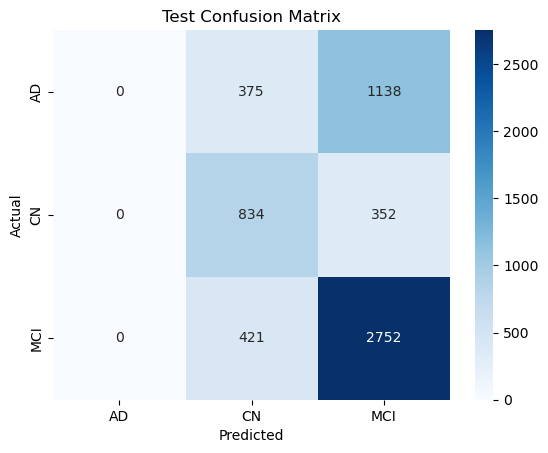

In [32]:
Show_confusion_matrix(model_2,test_gen_2)

In [34]:
# 🧪 Step 6: Load Data and Train Model on Dataset 2 (3 Classes)
# Path to 3-class Alzheimer dataset
train_path_3 = "C://Users//gm010//NN//Alzheimer_s Dataset//train"
# Assuming your test data is in this folder:
test_path_3 = "C://Users//gm010//NN//Alzheimer_s Dataset//test"
# Load data
train_3, val_3 = load_data(train_path_3)

# Load test data
test_gen_3 = load_test_data(test_path_3)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 89s 673ms/step - accuracy: 0.4441 - loss: 1.8272 - val_accuracy: 0.4555 - val_loss: 1.0898
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 394ms/step - accuracy: 0.5168 - loss: 0.9977 - val_accuracy: 0.4633 - val_loss: 1.0827
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 53s 410ms/step - accuracy: 0.5774 - loss: 0.8992 - val_accuracy: 0.4282 - val_loss: 1.0591
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.5747 - loss: 0.8845 - val_accuracy: 0.4370 - val_loss: 1.0959
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.5716 - loss: 0.8664 - val_accuracy: 0.3832 - val_loss: 1.1407
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 517ms/step - accuracy: 0.6013 - loss: 0.8233 - val_accuracy: 0.4291 - val_loss: 1.0744
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 545ms/step - accuracy: 0.6163 - loss: 0.8200 - val_accuracy: 0.4428 - val_loss: 1.0953
Epoch 8/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 61s 472ms/step - accuracy: 0.6199 - loss: 0

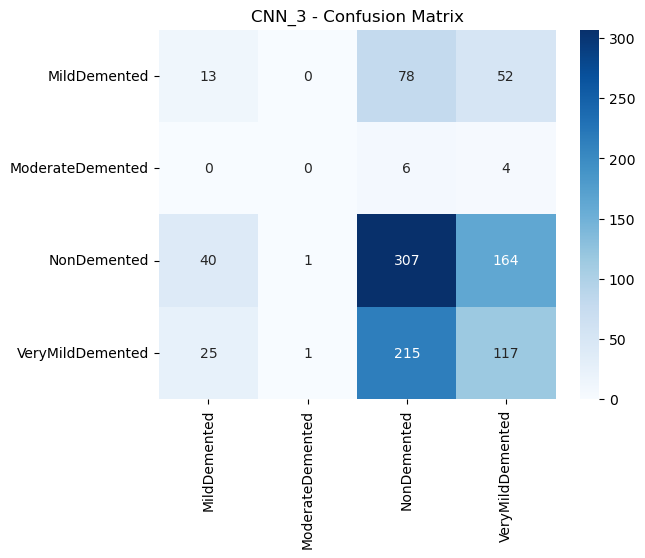

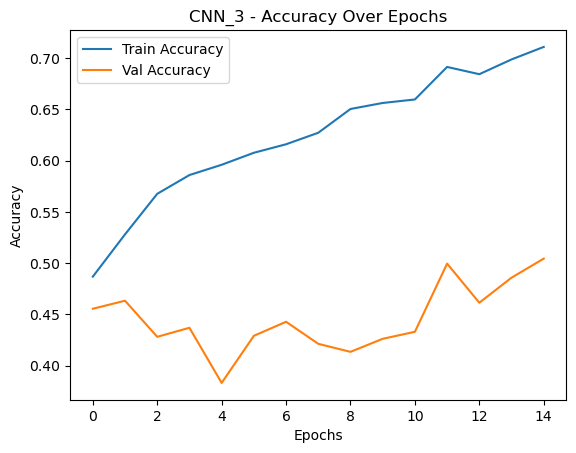

In [36]:
# Build CNN model with slightly less dropout
model_3_cnn = build_cnn_model(num_classes=4, dropout=0.3)

# Train and evaluate
history_3 = train_and_evaluate(model_3_cnn, train_3, val_3, name="CNN_3")

C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 396ms/step - accuracy: 0.4369 - loss: 11.1244 - val_accuracy: 0.4770 - val_loss: 2.2527
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 46s 358ms/step - accuracy: 0.5053 - loss: 1.5651 - val_accuracy: 0.4321 - val_loss: 2.0978
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 397ms/step - accuracy: 0.5269 - loss: 1.4740 - val_accuracy: 0.4682 - val_loss: 1.5191
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 49s 378ms/step - accuracy: 0.5008 - loss: 1.6061 - val_accuracy: 0.3949 - val_loss: 1.4293
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.5442 - loss: 1.2081 - val_accuracy: 0.4321 - val_loss: 1.3170
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 49s 382ms/step - accuracy: 0.5654 - loss: 0.9924 - val_accuracy: 0.4829 - val_loss: 1.4915
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 401ms/step - accuracy: 0.5590 - loss: 1.0158 - val_accuracy: 0.3920 - val_loss: 1.7246
Epoch 8/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 64s 501ms/step - accuracy: 0.5494 - loss: 

C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


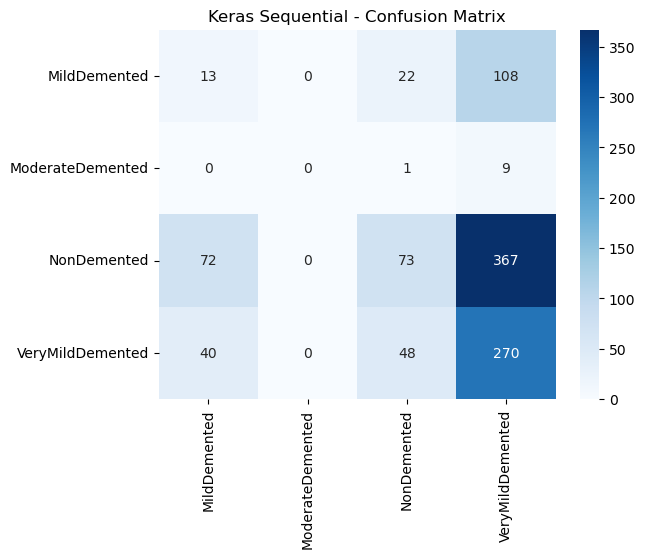

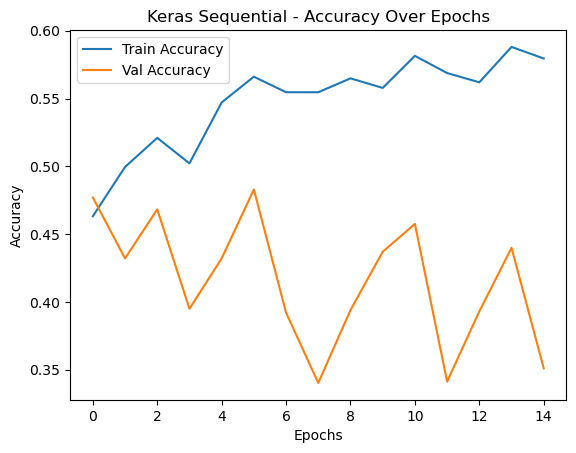

In [38]:
# 🧠 Build dense NN model
model_3 = build_sequential_model(num_classes=4)

# 🧪 Train on 4-class Alzheimer data
history_3 = train_and_evaluate(model_3, train_3, val_3, name="Keras Sequential")

C:\Users\gm010\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.2916 - loss: 1.8406
Test Loss: 1.1249
Test Accuracy: 0.4855
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.62      0.53      0.57       640
VeryMildDemented       0.38      0.63      0.48       448

        accuracy                           0.49      1279
       macro avg       0.25      0.29      0.26      1279
    weighted avg       0.45      0.49      0.45      1279



C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


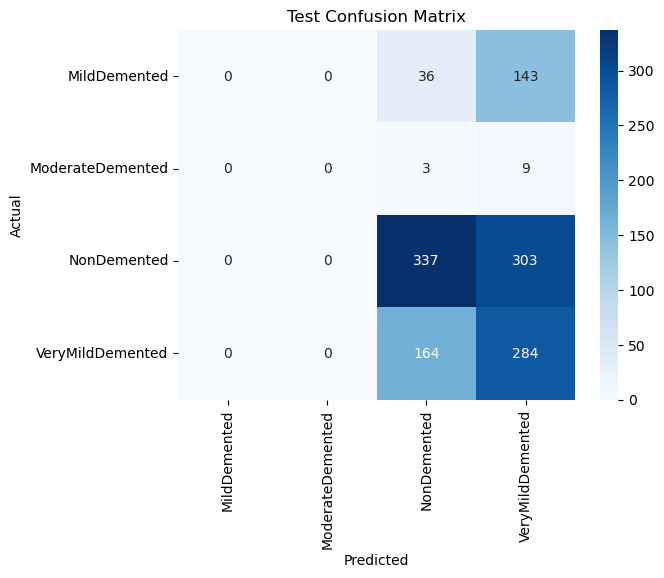

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4765 - loss: 1.8414
Test Loss: 1.1502
Test Accuracy: 0.5880
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    MildDemented       1.00      0.05      0.10       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.62      0.78      0.69       640
VeryMildDemented       0.53      0.55      0.54       448

        accuracy                           0.59      1279
       macro avg       0.54      0.34      0.33      1279
    weighted avg       0.63      0.59      0.55      1279



C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gm010\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


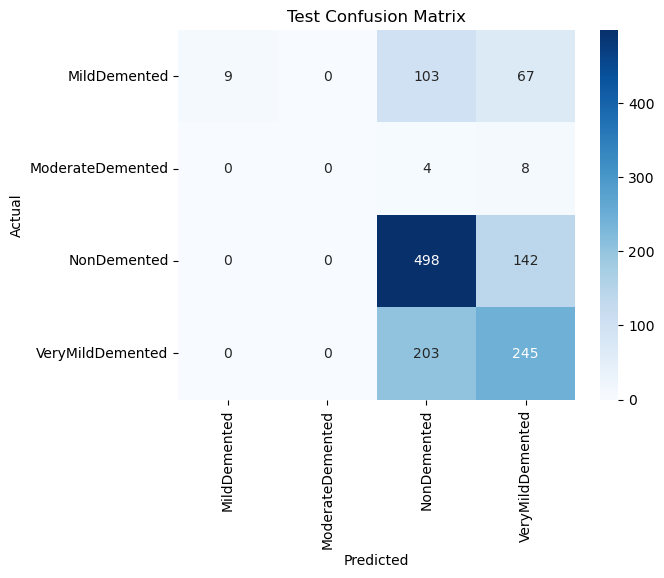

In [39]:
Show_confusion_matrix(model_3,test_gen_3)
Show_confusion_matrix(model_3_cnn,test_gen_3)